In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats


df = pd.read_csv("./data/ImmoDataRuhr.csv")
df = df.rename(columns={"regio2": "city", "sqmPrice": "price"})
cities = ["Bochum","Dortmund", "Duisburg", "Essen"]
PRICENAME = "Price per sqm in Euros"

In [2]:
# cleaning the data:
print(df[df["price"].isna()])
# --> no missing data

Empty DataFrame
Columns: [ID, price, city]
Index: []


In [3]:
print("mean")
print(df.groupby(by="city").mean())
print("\nstandrad deviation")
print(df.groupby(by="city").std())

print("\ncount")
print(df.groupby(by="city").count()) # 50 in each group --> perfect

mean
               ID     price
city                       
Bochum    6199.76  9.150398
Dortmund  6596.06  9.525716
Duisburg  6000.52  8.621169
Essen     6081.84  9.298602

standrad deviation
                   ID     price
city                           
Bochum    3351.817561  1.325280
Dortmund  4129.170181  1.355733
Duisburg  3275.133699  1.141194
Essen     3453.132499  1.187856

count
          ID  price
city               
Bochum    50     50
Dortmund  50     50
Duisburg  50     50
Essen     50     50


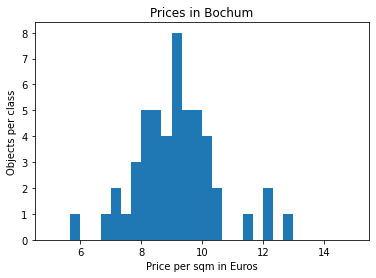

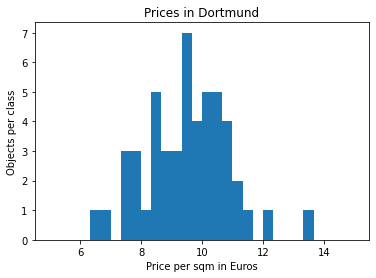

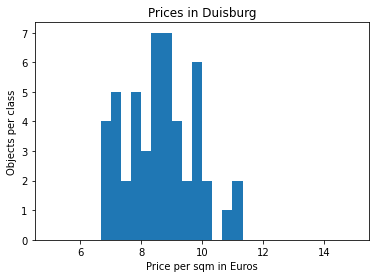

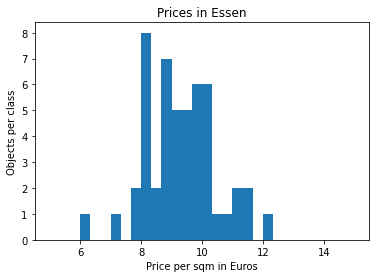

In [4]:

# test residuals qpproximately normal distributed
# just looking at histogram
for c in cities:
    arr = df[df["city"] == c]["price"]
    bins = np.arange(5,15,0.333333)
    fig, ax = plt.subplots()
    plt.hist(arr, bins=bins)
    ax.set_title("Prices in " + c)
    ax.set_xlabel(PRICENAME)
    ax.set_ylabel("Objects per class")
    fig.savefig(f"./latex/images/{c}-histogram.png", format='png', dpi=150)
    plt.show()

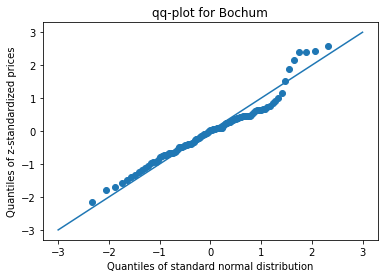

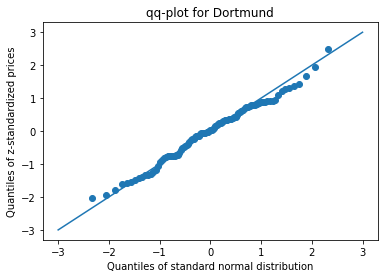

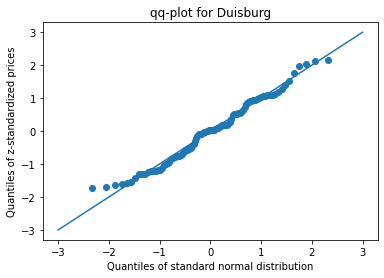

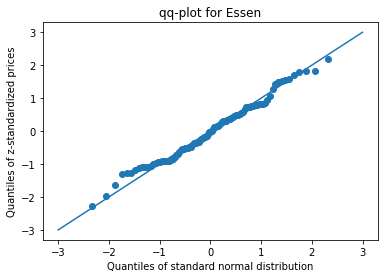

In [5]:
# qq plot with normal distribution:
linelimit = 3
quantilecount = 100
for c in cities:
    arr = df[df["city"] == c]["price"]
    mean = np.mean(arr)
    std = np.std(arr, ddof=0)
    quantilesSample = []
    quantilesNormal = []
    for i in range(quantilecount+1):
        q = i/quantilecount
        quantilesSample.append((np.quantile(arr,q)-mean)/std)
        quantilesNormal.append(stats.norm.ppf(q))
    fig, ax = plt.subplots()
    ax.set_title("qq-plot for " + c)
    ax.set_ylabel("Quantiles of z-standardized prices")
    ax.set_xlabel("Quantiles of standard normal distribution")
    plt.scatter(x= quantilesNormal, y=quantilesSample)
    plt.plot([-linelimit,linelimit],[-linelimit,linelimit])
    fig.savefig(f"./latex/images/{c}-qqplot.png", format='png', dpi=150)
    plt.show()

In [6]:
# homoscedasticity or Homogeneity of variances: variances equal within groups?

for c in cities:
    arr = df[df["city"] == c]["price"]
    print(f"Variance in {c}: {np.std(arr, ddof=0)**2}")

# they vary only by a factor of up to 1.41 which is okay.

Variance in Bochum: 1.721239273911677
Variance in Dortmund: 1.801250712661998
Variance in Duisburg: 1.276278179025029
Variance in Essen: 1.382781319087682


In [32]:
# Anova with 

cityToData = {
    city: [p for p in df[df["city"] == city]["price"]] for city in cities
}

def doAnova(cityList, alpha = 0.05):
    cityData = [cityToData[c] for c in cityList]
    F, p = stats.f_oneway(*cityData)
    Fkrit = stats.f.ppf(1-alpha,dfn=len(cityList)-1, dfd = 49* len(cityList))
    citystring = ", ".join(cityList)
    significant = "*" if p <= alpha else " "
    print(f"""Anova for cities: {citystring}
    F: {F}, Fkrit: {Fkrit}, alpha: {alpha}, p: {p} {significant}
    -------------------------------------------
    """)


doAnova(["Dortmund", "Bochum", "Duisburg", "Essen"], alpha=0.05)

doAnova(["Dortmund", "Bochum"], alpha=0.05)
doAnova(["Dortmund", "Bochum"], alpha=0.05/6)

doAnova(["Dortmund", "Duisburg"], alpha=0.05)
doAnova(["Dortmund", "Duisburg"], alpha=0.05/6)

doAnova(["Dortmund", "Essen"], alpha=0.05)
doAnova(["Dortmund", "Essen"], alpha=0.05/6)

doAnova(["Bochum", "Duisburg"], alpha=0.05)
doAnova(["Bochum", "Duisburg"], alpha=0.05/6)

doAnova(["Bochum", "Essen"], alpha=0.05)
doAnova(["Bochum", "Essen"], alpha=0.05/6)

doAnova(["Duisburg", "Essen"], alpha=0.05)
doAnova(["Duisburg", "Essen"], alpha=0.05/6)




Anova for cities: Dortmund, Bochum, Duisburg, Essen
    F: 4.6810872445745595, Fkrit: 2.6506765101121257, alpha: 0.05, p: 0.0035078387959125677 *
    -------------------------------------------
    
Anova for cities: Dortmund, Bochum
    F: 1.9594970515454322, Fkrit: 3.938111078003373, alpha: 0.05, p: 0.16472482873656977  
    -------------------------------------------
    
Anova for cities: Dortmund, Bochum
    F: 1.9594970515454322, Fkrit: 7.251539058150055, alpha: 0.008333333333333333, p: 0.16472482873656977  
    -------------------------------------------
    
Anova for cities: Dortmund, Duisburg
    F: 13.027367166434955, Fkrit: 3.938111078003373, alpha: 0.05, p: 0.00048571854391816404 *
    -------------------------------------------
    
Anova for cities: Dortmund, Duisburg
    F: 13.027367166434955, Fkrit: 7.251539058150055, alpha: 0.008333333333333333, p: 0.00048571854391816404 *
    -------------------------------------------
    
Anova for cities: Dortmund, Essen
    F: 0.